# [**Comparaison de l'étalonnage de classifieurs**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/1_16_calibration/plot_compare_calibration.ipynb)<br/>([_Comparison of Calibration of Classifiers_](https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html))

Les classifieurs correctement étalonnés sont des classifieurs probabilistes pour lesquels la sortie de [**`predict_proba`**](https://scikit-learn.org/stable/glossary.html#term-predict_proba) peut être directement interprétée comme un niveau de confiance. Par exemple, un classifieur binaire correctement étalonné devrait classifier les échantillons de telle manière que, pour les échantillons auxquels il a attribué une valeur [**`predict_proba`**](https://scikit-learn.org/stable/glossary.html#term-predict_proba) proche de 0,8, environ 80 % appartiennent réellement à la classe positive.

Dans cet exemple, nous allons comparer l'étalonnage de quatre modèles différents : la [**Régression logistique** (1.11.1)](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), le [**Classifieur naïf bayésien gaussien** (1.9.1)](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes), le [**Classifieur Random Forest** (1.11.2)](https://scikit-learn.org/stable/modules/ensemble.html#forest) et le [**SVM linéaire** (1.4.1)](https://scikit-learn.org/stable/modules/svm.html#svm-classification).

Auteur : Jan Hendrik Metzen <jhm@informatik.uni-bremen.de> Licence : BSD 3 clauses.

# Jeu de données

Nous utiliserons un jeu de données de classification binaire synthétique composé de 100 000 échantillons et 20 caractéristiques. Sur les 20 caractéristiques, seules 2 sont informatives, 2 sont redondantes (combinaisons aléatoires des caractéristiques informatives) et les 16 restantes sont non informatives (nombres aléatoires). Sur les 100 000 échantillons, 100 seront utilisés pour l'ajustement du modèle et le reste pour les tests.

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=2, random_state=42
)

train_samples = 100  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=100_000 - train_samples,
)

# Courbes d'étalonnage

Ci-dessous, nous entraînons chacun des quatre modèles avec le petit jeu de données d'entraînement, puis nous représentons les courbes d'étalonnage (également appelées diagrammes de fiabilité) en utilisant les probabilités prédites du jeu de données de test. Les courbes d'étalonnage sont créées en regroupant les probabilités prédites, puis en traçant la probabilité prédite moyenne dans chaque groupe par rapport à la fréquence observée (« fraction de positifs »). Sous la courbe d'étalonnage, nous représentons un histogramme montrant la distribution des probabilités prédites ou plus précisément, le nombre d'échantillons dans chaque groupe de probabilités prédites.

In [2]:
import numpy as np

from sklearn.svm import LinearSVC


class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        return np.c_[proba_neg_class, proba_pos_class]

In [3]:
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0, dual="auto")
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]

c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\calibration.py:1198: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = self.ax_.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\calibration.py:1198: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = self.ax_.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[
c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\calibration.py:1198: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = self.ax_.plot(self.prob_pred, sel

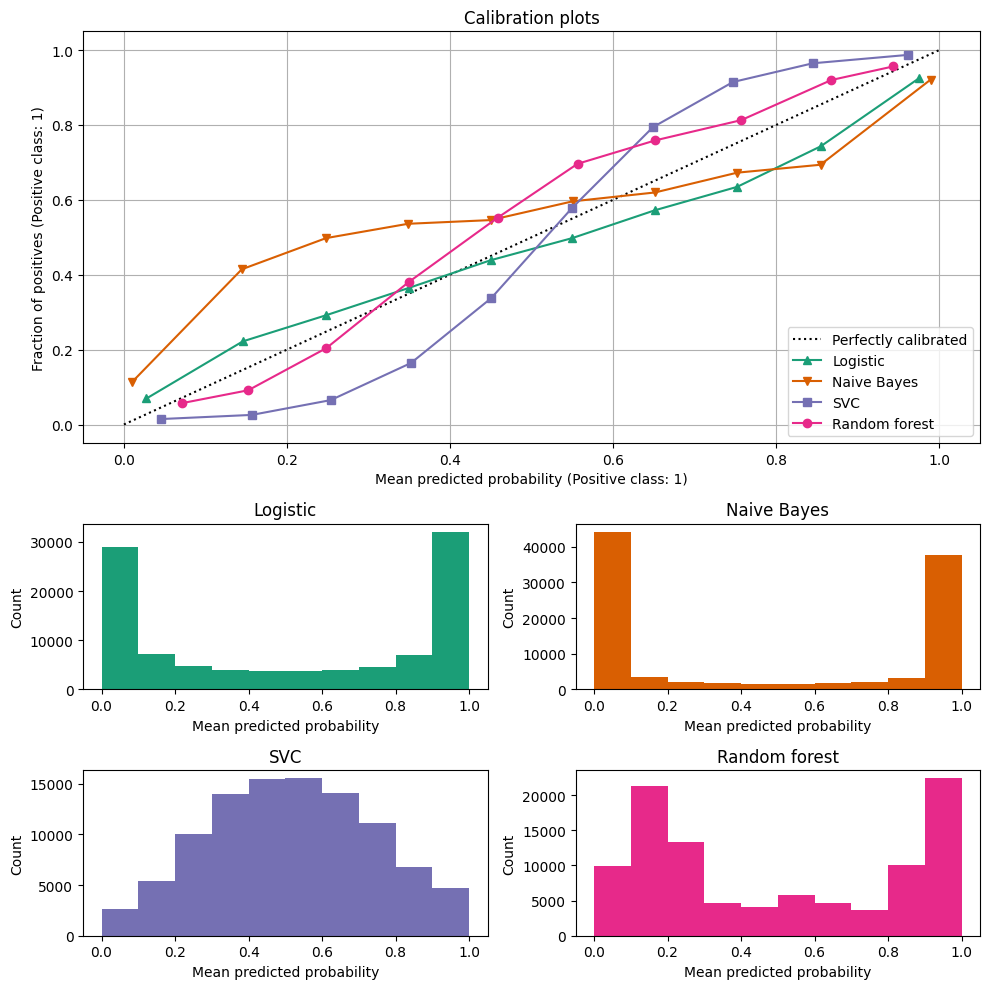

In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

> **NDLR :** redondance de ce qui suit avec la section [**Courbes d'étalonnage** (1.16.1)]((https://scikit-learn.org/stable/modules/calibration.html#calibration-curves)) de la documentation.

[**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) renvoie des prédictions bien étalonnées car il optimise directement la perte logarithmique. En revanche, les autres méthodes renvoient des probabilités biaisées, avec des biais différents pour chaque méthode :
- [**`GaussianNB`**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) a tendance à pousser les probabilités vers 0 ou 1 (voir l'histogramme). Cela est principalement dû au fait que l'équation du naïf Bayes ne fournit une estimation correcte des probabilités que lorsque l'hypothèse d'indépendance conditionnelle des caractéristiques est respectée [2]. Cependant, les caractéristiques ont tendance à être positivement corrélées, ce qui est le cas avec ce jeu de données, qui contient 2 caractéristiques générées comme des combinaisons linéaires aléatoires des caractéristiques informatives. Ces caractéristiques corrélées sont effectivement "comptées deux fois", ce qui pousse les probabilités prédites vers 0 et 1 [3].
- [**`RandomForestClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) montre un comportement opposé : les histogrammes montrent des pics à environ 0,2 et 0,9 de probabilité, tandis que les probabilités proches de 0 ou 1 sont très rares. Une explication à cela est donnée par Niculescu-Mizil et Caruana [1] : _"Les méthodes telles que le bagging et les forêts aléatoires qui moyennent les prédictions à partir d'un ensemble de modèles de base peuvent avoir des difficultés à faire des prédictions proches de 0 et de 1 car la variance des modèles de base sous-jacents biaisera les prédictions qui devraient être proches de zéro ou un loin de ces valeurs. Comme les prédictions sont limitées à l'intervalle $[0, 1]$, les erreurs dues à la variance ont tendance à être unilatérales près de zéro et de un. Par exemple, si un modèle doit prédire $p = 0$ pour un cas, la seule façon pour le bagging d'y parvenir est que tous les arbres baggés prédisent zéro. Si nous ajoutons du bruit aux arbres que le bagging moyenne, ce bruit fera que certains arbres prédisent des valeurs supérieures à zéro pour ce cas, éloignant ainsi la prédiction moyenne de l'ensemble baggé de zéro. Nous observons cet effet de manière plus prononcée avec les forêts aléatoires car les arbres de niveau de base formés avec les forêts aléatoires ont une variance relativement élevée en raison de la sous-échantillonnage des caractéristiques."_ En conséquence, la courbe d'étalonnage montre une forme caractéristique en forme de sigmoïde, indiquant que le classifieur manque de confiance et pourrait renvoyer des probabilités plus proches de 0 ou 1.
- Pour montrer les performances de [**`LinearSVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC), nous mettons naïvement à l'échelle la sortie de la [**`decision_function`**](https://scikit-learn.org/stable/glossary.html#term-decision_function) dans $[0, 1]$ en appliquant une mise à l'échelle min-max, car le SVC n'émet pas de probabilités par défaut. [**`LinearSVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) montre une courbe encore plus en forme de sigmoïde que le [**`RandomForestClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier), ce qui est typique des méthodes à marge maximale [1] car elles se concentrent sur les échantillons difficiles à classer qui sont proches de la frontière de décision (les vecteurs de support).

# Références

🔬 [1] (1,2) [**“Predicting Good Probabilities With Supervised Learning”**](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.60.7135&rep=rep1&type=pdf), A. Niculescu-Mizil & R. Caruana, ICML 2005

🔬 [2] [**“Beyond Independence: Conditions for the Optimality of the Simple Bayesian Classier”**](https://www.ics.uci.edu/~pazzani/Publications/mlc96-pedro.pdf) Domingos, P., & Pazzani, M., Proc. 13th Intl. Conf. Machine Learning. 1996.

🔬 [3] [**“Obtaining calibrated probability estimates from decision trees and naive Bayesian classifiers”**](https://cseweb.ucsd.edu//~elkan/calibrated.pdf) Zadrozny, Bianca, and Charles Elkan. Icml. Vol. 1. 2001.